In [1]:
# Install necessary packages
!pip install transformers torch scikit-learn seaborn

In [2]:
# Import necessary libraries
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
!wget https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/train.csv -O train.csv
!wget https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/validation.csv -O validation.csv
!wget https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/test.csv -O test.csv

--2024-05-22 15:44:19--  https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2804689 (2.7M) [text/plain]
Saving to: 'train.csv'

train.csv           100%[===================>]   2.67M  --.-KB/s    in 0.07s   

2024-05-22 15:44:19 (36.6 MB/s) - 'train.csv' saved [2804689/2804689]

--2024-05-22 15:44:20--  https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/validation.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting re

In [4]:
train_df = pd.read_csv('train.csv', delimiter=';')
test_df = pd.read_csv('test.csv', delimiter=';')
val_df = pd.read_csv('validation.csv', delimiter=';')

print(train_df.head())
print(test_df.head())
print(val_df.head())

      screen_name                                               text  \
0      imranyebot                             YEA now that note GOOD   
1          zawvrk  Listen to This Charming Man by The Smiths  htt...   
2        zawarbot  wish i can i would be seeing other hoes on the...   
3  ahadsheriffbot  The decade in the significantly easier schedul...   
4   kevinhookebot  "Theim class=\"alignnone size-full wp-image-60...   

  account.type class_type  
0          bot     others  
1        human      human  
2          bot     others  
3          bot     others  
4          bot        rnn  
      screen_name                                               text  \
0          zawvrk  justin timberlake really one of the goats if y...   
1    narendramodi  Thank you @PMBhutan for your gracious prayers ...   
2     ahadsheriff  Theory: the number of red lights you will hit ...   
3  AINarendraModi  Respects on the Upt of the I good with the peo...   
4      kevinhooke  Might give the BASIC

In [5]:
train_df.shape

(20712, 4)

In [6]:
# Drop 'class_type' and 'screen_name' columns from test_df
test_df = test_df.drop(columns=['class_type', 'screen_name'])

# Drop 'class_type' and 'screen_name' columns from train_df and val_df similarly
train_df = train_df.drop(columns=['class_type', 'screen_name'])
val_df = val_df.drop(columns=['class_type', 'screen_name'])

In [7]:
# Clean the text
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace
    return text

In [8]:
val_df['cleaned_text'] = val_df['text'].apply(clean_text)

In [9]:
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

In [10]:
train_df['cleaned_text'] = train_df['text'].apply(clean_text)

In [11]:
# Encode labels
label_mapping = {'human': 0, 'bot': 1,}
val_df['label'] = val_df['account.type'].map(label_mapping)

In [12]:
val_df

,text,account.type,cleaned_text,label
0,"TIGHT, TIGHT, TIGHT, YEAH!!! https://t.co/wj3n...",human,tight tight tight yeah,0
1,India has millennia old relations with Oman. W...,human,india has millennia old relations with oman we...,0
2,Anxious Teenagers,human,anxious teenagers,0
3,Our top priority is keeping Canadians safe. Wi...,human,our top priority is keeping canadians safe wit...,0
4,nah bro You’re taking sis so much I’m just a g...,bot,nah bro youre taking sis so much im just a goo...,1
...,...,...,...,...
2297,You're going to be even prouder when we don't ...,bot,youre going to be even prouder when we dont ha...,1
2298,https://t.co/10XkzXDBCf https://t.co/cIUIYWEB45,human,,0
2299,2. “Once you take the place of the people who ...,human,once you take the place of the people who live...,0
2300,black will be like a company with them need so...,bot,black will be like a company with them need so...,1


In [13]:
train_df['label'] = train_df['account.type'].map(label_mapping)
test_df['label'] = test_df['account.type'].map(label_mapping)

In [14]:
# Drop 'class_type' and 'screen_name' columns from test_df
test_df = test_df.drop(columns=['account.type', 'text'])

# Drop 'class_type' and 'screen_name' columns from train_df and val_df similarly
train_df = train_df.drop(columns=['account.type', 'text'])
val_df = val_df.drop(columns=['account.type', 'text'])

In [15]:
train_df

,cleaned_text,label
0,yea now that note good,1
1,listen to this charming man by the smiths,0
2,wish i can i would be seeing other hoes on the...,1
3,the decade in the significantly easier schedul...,1
4,theim classalignnone sizefull wpimage src alt ...,1
...,...,...
20707,met on the abversion of our science for the co...,1
20708,land for their during the opportunity to the p...,1
20709,doesnt have a clue youre right we love our cou...,1
20710,me and my bestie,0


In [16]:
y_train = train_df["label"]
y_val = val_df["label"]
y_test = test_df["label"]

In [17]:
y_train

0        1
1        0
2        1
3        1
4        1
        ..
20707    1
20708    1
20709    1
20710    0
20711    1
Name: label, Length: 20712, dtype: int64

In [18]:
# Define a custom Dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label)
        return item

In [19]:
# Tokenizer initialization
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [20]:
# Create datasets
train_dataset = TweetDataset(train_df['cleaned_text'], train_df['label'], tokenizer, max_length=128)
val_dataset = TweetDataset(val_df['cleaned_text'], val_df['label'], tokenizer, max_length=128)
test_dataset = TweetDataset(test_df['cleaned_text'], test_df['label'], tokenizer, max_length=128)

In [21]:
# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [25]:
# Define a custom model with dropout and batch normalization for regularization
class CustomRobertaForSequenceClassification(torch.nn.Module):
    def __init__(self, model_name='roberta-base', num_labels=2):
        super(CustomRobertaForSequenceClassification, self).__init__()
        self.roberta = RobertaModel.from_pretrained(model_name)
        self.dropout = torch.nn.Dropout(0.5)  # Increased dropout rate to 50%
        self.batch_norm = torch.nn.BatchNorm1d(768)
        self.classifier = torch.nn.Linear(768, num_labels)
        
    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0][:, 0, :]
        sequence_output = self.batch_norm(sequence_output)
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)
        
        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
            
        return loss, logits

In [27]:
# Initialize the custom model
model = CustomRobertaForSequenceClassification()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
       

In [30]:
# Define optimizer and scheduler with stronger regularization
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.1)  # Reduced learning rate and increased weight decay
total_steps = len(train_loader) * 10  # 10 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [31]:
# Training function
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    preds = []
    labels = []
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)
        labels.extend(batch_labels.cpu().numpy())
        loss, logits = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(batch_preds)
    accuracy = accuracy_score(labels, preds)
    return total_loss / len(data_loader), accuracy

In [32]:
# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    preds = []
    labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['labels'].to(device)
            labels.extend(batch_labels.cpu().numpy())
            loss, logits = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
            total_loss += loss.item()
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)
    accuracy = accuracy_score(labels, preds)
    metrics = precision_recall_fscore_support(labels, preds, average='weighted')
    avg_loss = total_loss / len(data_loader)
    return accuracy, metrics, labels, preds, avg_loss

In [33]:
# Training loop with early stopping
epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 2

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_acc, val_metrics, val_true_labels, val_preds, val_loss = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    print(f"Validation Metrics (Precision, Recall, F1): {val_metrics}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

Epoch 1/10
Train Loss: 0.5643 | Train Accuracy: 0.7150
Validation Loss: 0.4208 | Validation Accuracy: 0.7919
Validation Metrics (Precision, Recall, F1): (0.8023028252802735, 0.7919200695047784, 0.7901403738854142, None)
Epoch 2/10
Train Loss: 0.4449 | Train Accuracy: 0.7867
Validation Loss: 0.4131 | Validation Accuracy: 0.7932
Validation Metrics (Precision, Recall, F1): (0.8090262099915577, 0.7932232841007819, 0.7905725032134058, None)
Epoch 3/10
Train Loss: 0.3689 | Train Accuracy: 0.8339
Validation Loss: 0.4241 | Validation Accuracy: 0.8006
Validation Metrics (Precision, Recall, F1): (0.817739364833297, 0.8006081668114683, 0.7979101316582856, None)
Epoch 4/10
Train Loss: 0.2948 | Train Accuracy: 0.8722
Validation Loss: 0.4060 | Validation Accuracy: 0.8189
Validation Metrics (Precision, Recall, F1): (0.8241595051442777, 0.8188531711555169, 0.8181216414637766, None)
Epoch 5/10
Train Loss: 0.2303 | Train Accuracy: 0.9070
Validation Loss: 0.5043 | Validation Accuracy: 0.8167
Validation M

In [34]:
# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [35]:
# Evaluate on the test set and plot results
test_acc, test_metrics, true_labels, predicted_labels, test_loss = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Metrics (Precision, Recall, F1): {test_metrics}")

Test Accuracy: 0.8241
Test Metrics (Precision, Recall, F1): (0.8299271251692213, 0.8240813135261923, 0.8233101500998206, None)


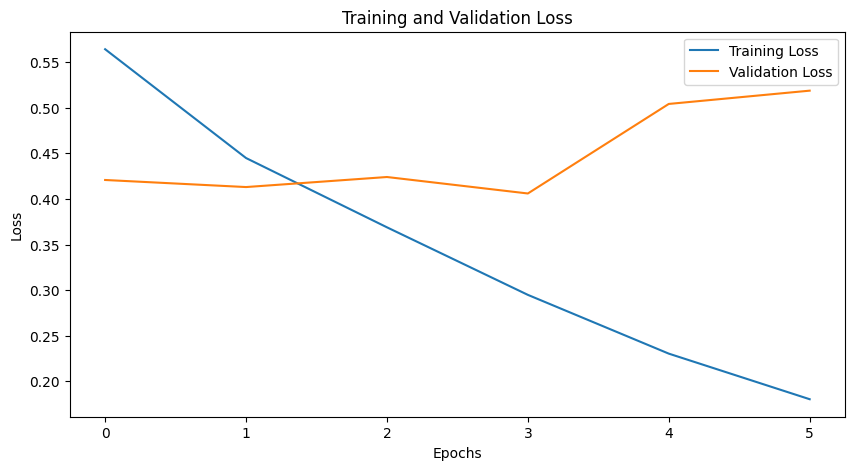

In [36]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

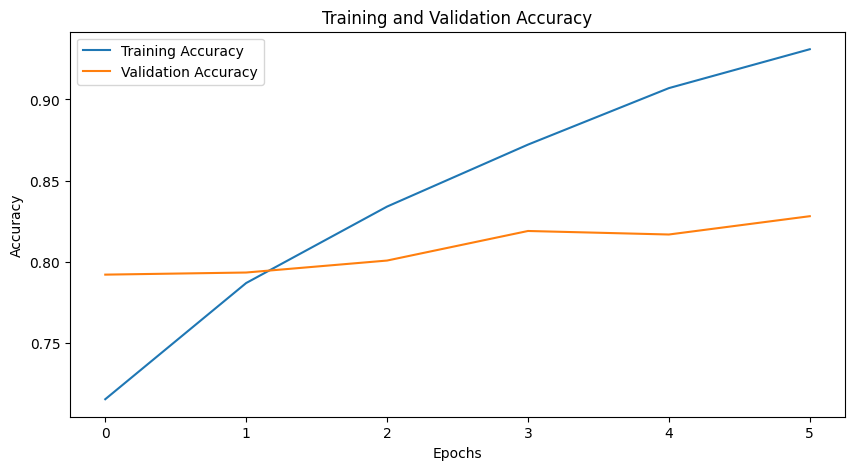

In [37]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [38]:
# Define the reverse label mapping
dictLabelsReverse = {0: "human", 1: "bot"}

# Map the numerical predictions and true labels to the original labels
true_labels_mapped = [dictLabelsReverse[label] for label in true_labels]
predicted_labels_mapped = [dictLabelsReverse[label] for label in predicted_labels]

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Text': test_df['cleaned_text'],
    'True Label': true_labels_mapped,
    'Predicted Label': predicted_labels_mapped
})

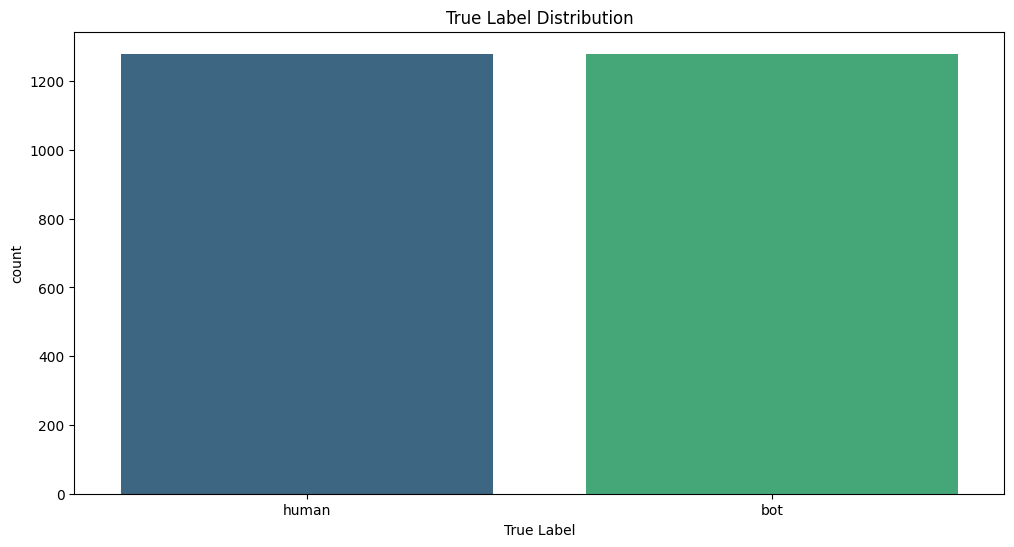

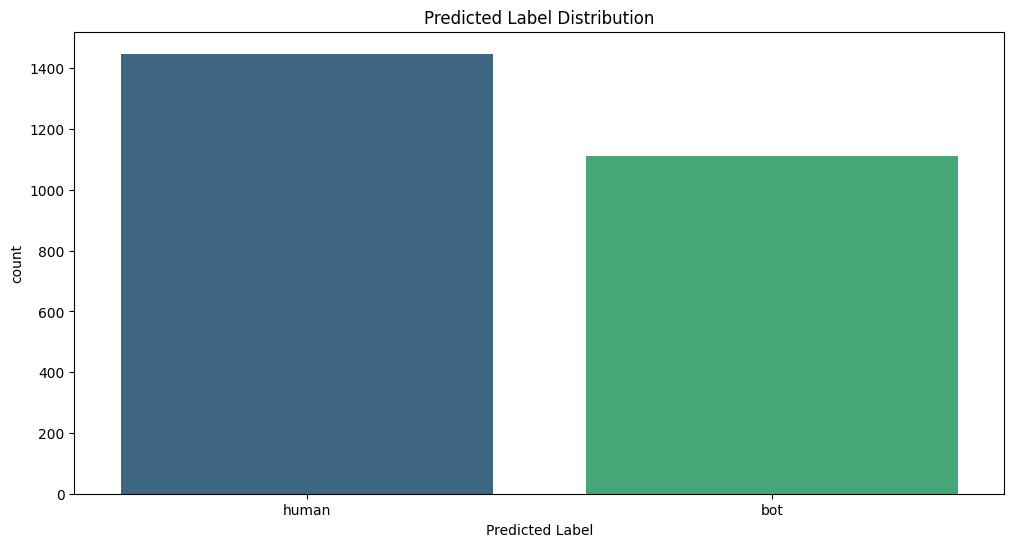

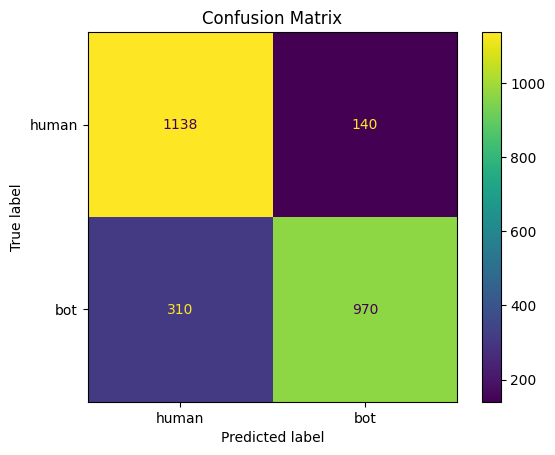

In [39]:
# Plotting
plt.figure(figsize=(12, 6))
sns.countplot(x='True Label', data=plot_df, palette='viridis')
plt.title('True Label Distribution')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='Predicted Label', data=plot_df, palette='viridis')
plt.title('Predicted Label Distribution')
plt.show()

# Plot confusion matrix
cm = confusion_matrix(plot_df['True Label'], plot_df['Predicted Label'], labels=["human", "bot"])
cmd = ConfusionMatrixDisplay(cm, display_labels=["human", "bot"])
cmd.plot()
plt.title('Confusion Matrix')
plt.show()


In [40]:
# Sample some texts from the test set along with their true and predicted labels
num_samples = 30  # Number of samples to display
sample_df = plot_df.sample(n=num_samples)

print("\nSampled Texts with True and Predicted Labels from Test Set:")
for index, row in sample_df.iterrows():
    print(f"Text: {row['Text']}")
    print(f"True Label: {row['True Label']}")
    print(f"Predicted Label: {row['Predicted Label']}")
    print()


Sampled Texts with True and Predicted Labels from Test Set:
Text: it releases and
True Label: bot
Predicted Label: bot

Text: the disk from the may not singleted in the cloudadactbase not set some some synter of the config code in port while what the requestion of the new or java ee orgapplications some pass to a start and
True Label: bot
Predicted Label: bot

Text: in the year the mining corporation zenimax releases a game entitled the elder scrolls v skyrim
True Label: bot
Predicted Label: human

Text: the templet or docs to printion then the web apps wirey running to the code of the install this is frace the installing so far beans of defaults the default of device of the make a network in the conso
True Label: bot
Predicted Label: bot

Text: standup smh
True Label: human
Predicted Label: human

Text: my allahuakbar tik toks perform x better than my other tik toks so it looks like i wont be rebranding
True Label: human
Predicted Label: human

Text: whale maybe now when we whaleslap